In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Loading MNIST dataset

In [2]:
transform = transforms.ToTensor()
train_data= datasets.MNIST(root='data', download= True, train= True, transform= transform)
test_data= datasets.MNIST(root='data', download= True, train= False, transform= transform)
batch_size= 20
train_loader= torch.utils.data.DataLoader(train_data, batch_size= batch_size)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size)

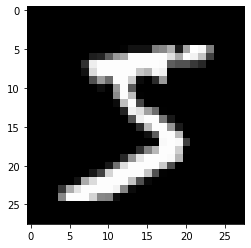

In [3]:
dataiter= iter(train_loader)
images, _= dataiter.next()
images= images.numpy().squeeze()
plt.imshow(images[0], cmap='gray')

## Convolutional Autoencoder using transpose convolutional layers
__Encoder__
In convolutional autoencoder we encode images using convolutional and pooling layers to compress the images. Here I used 2 convolutional layers to compress the input images from (1,28,28) to (4, 7, 7).

__Decoder__ 
The compressed output can be decoded using transpose Convolutional layers with a kernal size of (2,2) and a stride of greater than 1. These layers will increase the height and width of input images. 

In [5]:
import torch.nn as nn
import torch.nn.functional as f

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder,self).__init__()
        self.conv1= nn.Conv2d(1, 16, 3, padding=1)
        self.conv2= nn.Conv2d(16, 4, 3, padding=1)
        self.pool= nn.MaxPool2d(2,2)
        self.tconv1= nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.tconv2= nn.ConvTranspose2d(16, 1, 2, stride= 2)
    def forward(self,x):
        # Encoder
        x= self.pool(f.relu(self.conv1(x)))
        x= self.pool(f.relu(self.conv2(x)))
        #Decoder
        x= f.relu(self.tconv1(x))
        x= f.sigmoid(self.tconv2(x))
        return x
    
model= ConvAutoencoder()
print(model)
        

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tconv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (tconv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [9]:
criterion= nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

## Training 

In [10]:
epochs= 20
for epoch in range(epochs):
    train_loss= 0.0
    
    for images, _ in train_loader:
        optimizer.zero_grad()
        output= model(images)
        loss= criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()*images.size(0)
    train_loss= train_loss/ len(train_loader)
    print("Epoch: {} \tTraining loss: {:.6f}".format(epoch+1, train_loss))

C:\Users\Avi\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training loss: 0.577588
Epoch: 2 	Training loss: 0.352790
Epoch: 3 	Training loss: 0.313590
Epoch: 4 	Training loss: 0.292680
Epoch: 5 	Training loss: 0.282570
Epoch: 6 	Training loss: 0.276656
Epoch: 7 	Training loss: 0.272587
Epoch: 8 	Training loss: 0.269555
Epoch: 9 	Training loss: 0.267311
Epoch: 10 	Training loss: 0.264828
Epoch: 11 	Training loss: 0.262541
Epoch: 12 	Training loss: 0.260985
Epoch: 13 	Training loss: 0.259682
Epoch: 14 	Training loss: 0.258533
Epoch: 15 	Training loss: 0.257493
Epoch: 16 	Training loss: 0.256575
Epoch: 17 	Training loss: 0.255719
Epoch: 18 	Training loss: 0.254899
Epoch: 19 	Training loss: 0.254138
Epoch: 20 	Training loss: 0.253433


## Testing and Visualizing results

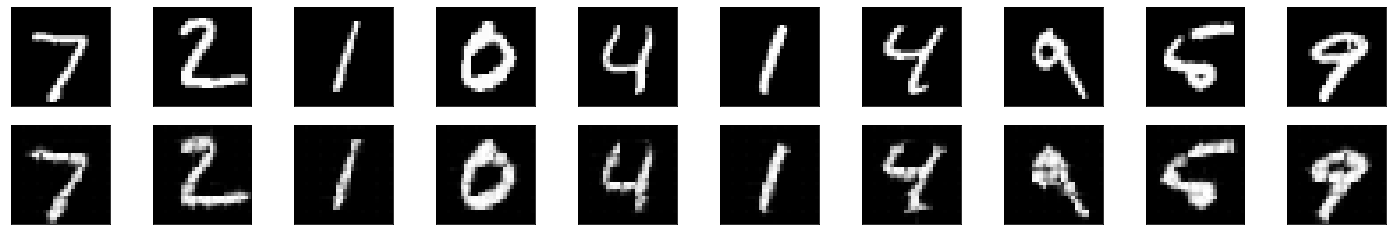

In [21]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

These perform better than the __Linear Autoencoders__ but the generated images are not smooth around the corners. These results can be improved by using __Upsampling__ instead of transpose convolutional layers during decoding.

## Convolutional autoencoder using Upsampling

In [22]:
class Autoencoders_upsampling(nn.Module):
    def __init__(self):
        super(Autoencoders_upsampling, self).__init__()
        self.conv1= nn.Conv2d(1, 16, 3, padding= 1)
        self.conv2= nn.Conv2d(16, 4, 3, padding= 1)
        self.conv3= nn.Conv2d(4, 16, 3, padding= 1)
        self.conv4= nn.Conv2d(16, 1, 3, padding= 1)
        self.pool= nn.MaxPool2d(2,2)
    def forward(self, x):
        x= self.pool(f.relu(self.conv1(x)))
        x= self.pool(f.relu(self.conv2(x)))
        x= f.upsample(x, scale_factor= 2, mode='nearest')
        x= f.relu(self.conv3(x))
        x= f.upsample(x, scale_factor= 2, mode='nearest')
        x= f.sigmoid(self.conv4(x))
        return x
    
model_upsample= Autoencoders_upsampling()
print(model_upsample)

Autoencoders_upsampling(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [23]:
criterion= nn.MSELoss()
optimizer= torch.optim.Adam(model_upsample.parameters(), lr= 0.001)

In [24]:
epochs= 20
for epoch in range(epochs):
    train_loss= 0.0
    
    for images, _ in train_loader:
        optimizer.zero_grad()
        output= model_upsample(images)
        loss= criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()*images.size(0)
    train_loss= train_loss/ len(train_loader)
    print("Epoch: {} \tTraining loss: {:.6f}".format(epoch+1, train_loss))

Epoch: 1 	Training loss: 0.316961
Epoch: 2 	Training loss: 0.155340
Epoch: 3 	Training loss: 0.139751
Epoch: 4 	Training loss: 0.132654
Epoch: 5 	Training loss: 0.128682
Epoch: 6 	Training loss: 0.125851
Epoch: 7 	Training loss: 0.123569
Epoch: 8 	Training loss: 0.121355
Epoch: 9 	Training loss: 0.119355
Epoch: 10 	Training loss: 0.117797
Epoch: 11 	Training loss: 0.116400
Epoch: 12 	Training loss: 0.115224
Epoch: 13 	Training loss: 0.114123
Epoch: 14 	Training loss: 0.113183
Epoch: 15 	Training loss: 0.112393
Epoch: 16 	Training loss: 0.111723
Epoch: 17 	Training loss: 0.111126
Epoch: 18 	Training loss: 0.110616
Epoch: 19 	Training loss: 0.110185
Epoch: 20 	Training loss: 0.109807


## Visualizing and comparing results

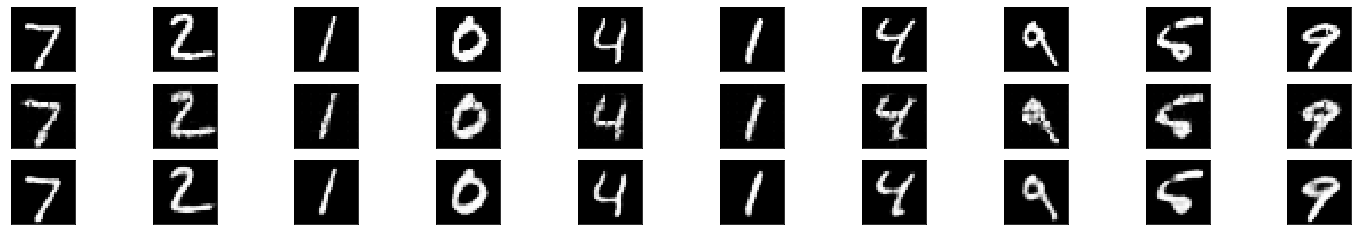

In [28]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output1 = model(images)
output2 = model_upsample(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output1 = output1.view(batch_size, 1, 28, 28)
output2 = output2.view(batch_size, 1, 28, 28)

output1 = output1.detach().numpy()
output2 = output2.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output1, output2], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)